In [1]:
import pandas as pd
import skimage
import matplotlib.pyplot as plt
import numpy as np
import easyocr
import itertools
from sklearn.model_selection import train_test_split

reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory


from IPython.display import Image, display

ANNOTATIONS_FILE = "annotations.pkl"
IMAGE_PREFIX = "../data/train/images/"

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [2]:
annotations = pd.read_pickle(ANNOTATIONS_FILE)
annotations = annotations[annotations['chart-type'] == 'vertical_bar']
annotations.head()

,source,chart-type,plot-bb,text,axes,data-series,image
1,generated,vertical_bar,"{'height': 164, 'width': 393, 'x0': 68, 'y0': 37}","[{'id': 0, 'polygon': {'x0': 109, 'x1': 355, '...","{'x-axis': {'ticks': [{'id': 11, 'tick_pt': {'...","[{'x': 'Jordan', 'y': 88.35159235668789}, {'x'...",75c0449f6917.jpg
3,generated,vertical_bar,"{'height': 165, 'width': 396, 'x0': 89, 'y0': 60}","[{'id': 0, 'polygon': {'x0': 71, 'x1': 465, 'x...","{'x-axis': {'ticks': [{'id': 14, 'tick_pt': {'...","[{'x': 'Cuba', 'y': 75695.38632268383}, {'x': ...",58595c30beab.jpg
6,generated,vertical_bar,"{'height': 103, 'width': 408, 'x0': 52, 'y0': 65}","[{'id': 0, 'polygon': {'x0': 49, 'x1': 417, 'x...","{'x-axis': {'ticks': [{'id': 14, 'tick_pt': {'...","[{'x': 'Jamaica', 'y': 36.43411033235605}, {'x...",5022600d52d7.jpg
10,generated,vertical_bar,"{'height': 210, 'width': 427, 'x0': 50, 'y0': 36}","[{'id': 0, 'polygon': {'x0': 28, 'x1': 42, 'x2...","{'x-axis': {'ticks': [{'id': 8, 'tick_pt': {'x...","[{'x': '1', 'y': 62.45402663284719}, {'x': '2'...",32176a89b822.jpg
14,generated,vertical_bar,"{'height': 220, 'width': 427, 'x0': 64, 'y0': 38}","[{'id': 0, 'polygon': {'x0': 74, 'x1': 473, 'x...","{'x-axis': {'ticks': [{'id': 14, 'tick_pt': {'...","[{'x': 'Harney', 'y': 75.91000641635438}, {'x'...",3d895e511690.jpg


In [3]:
annotations_train, annotations_test = train_test_split(annotations.sample(50, random_state=123), test_size=0.2)


[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


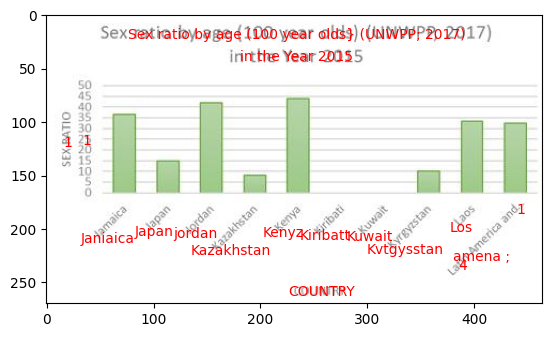

In [33]:
from skimage.color import rgb2gray
from skimage.filters import sobel, unsharp_mask

def extract_labels(image_path: str):
    image = skimage.io.imread(IMAGE_PREFIX + image_path)
    # image = (sobel(image)*255).astype(np.uint8)

    gray = rgb2gray(image)
     # Threshold the image to create a binary mask
    thresh = skimage.filters.threshold_otsu(gray)
    binary = gray > thresh
    binary = (binary*255).astype(np.uint8)

    print(binary)

    texts = reader.readtext(binary)
    plt.imshow(image)
    for coord, text, _ in texts:
        plt.text((coord[0][0] + coord[1][0])/2, (coord[0][1] + coord[3][1])/2, text, c='r',
                    horizontalalignment='center',
                    verticalalignment='center',)
    plt.show()

extract_labels("5022600d52d7.jpg")

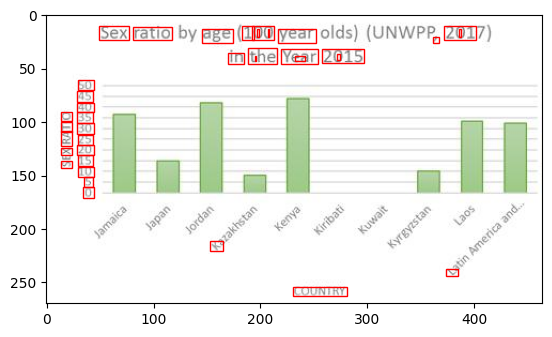

In [77]:
from skimage.color import rgb2gray
from skimage.filters import sobel, unsharp_mask
from skimage import measure
from skimage.segmentation import expand_labels, watershed
import scipy.ndimage as ndi
from matplotlib.patches import Rectangle

def expand_horizontally(image):
    return ndi.correlate(image, [[1,1,1]])

def extract_labels(image_path: str):
    image = skimage.io.imread(IMAGE_PREFIX + image_path)
    gray = rgb2gray(image)

     # Threshold the image to create a binary mask
    thresh = skimage.filters.threshold_otsu(gray)
    binary = gray < thresh

    binary = expand_horizontally(binary)

    # Label connected regions in the binary mask
    labels = measure.label(binary)
    # labels = expand_labels(labels, 1)
    # Find contours of labeled regions
    contours = measure.find_contours(labels, 0.5)
    # Loop over the contours and find the minimum bounding rectangle for each

    rectangles = []
    for contour in contours:
        # Ignore contours with less than four points (not a rectangle)
        if  len(contour) < 2:
            continue

        y_min, x_min = contour.min(axis=0)
        y_max, x_max = contour.max(axis=0)

        width = x_max - x_min
        height = y_max - y_min

        if height < 15 and height > 5:
        # plt.scatter(contour[:,1], contour[:,0], s=1)
            plt.gca().add_patch(Rectangle((x_min, y_min), width, height, facecolor="none", ec='r', lw=1))

    plt.imshow(image)
    plt.show()

extract_labels("5022600d52d7.jpg")

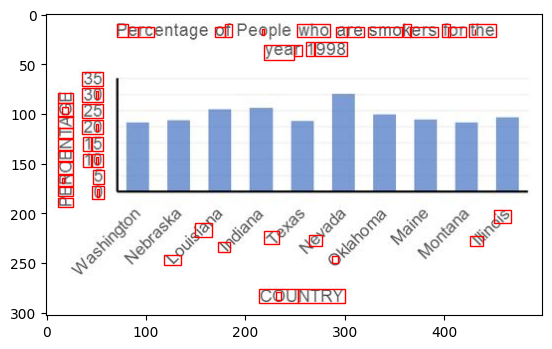

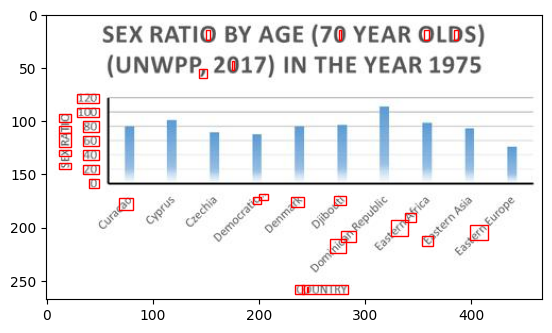

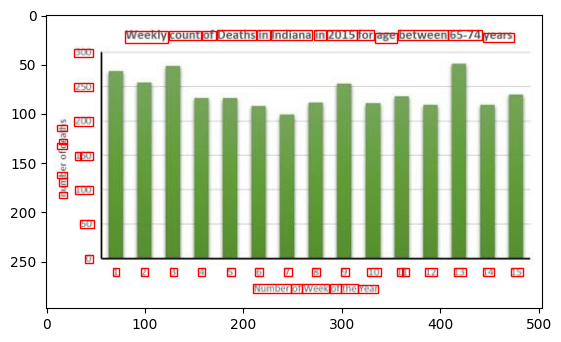

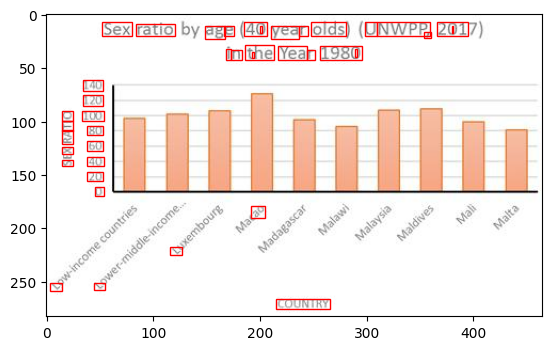

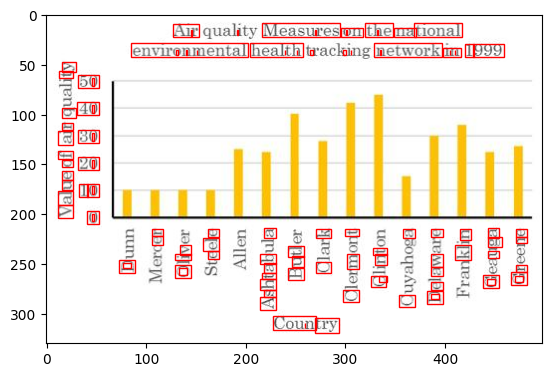

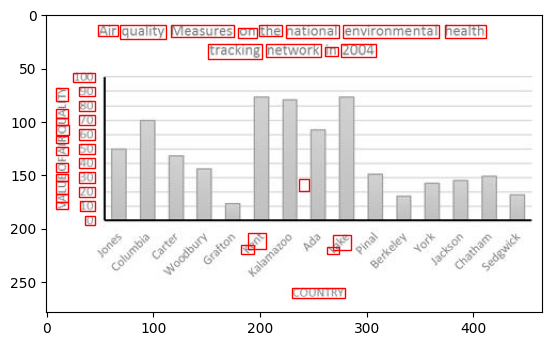

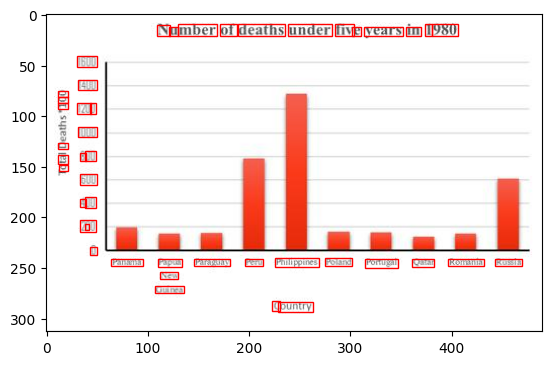

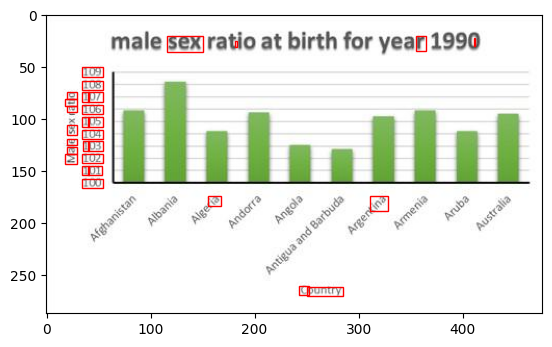

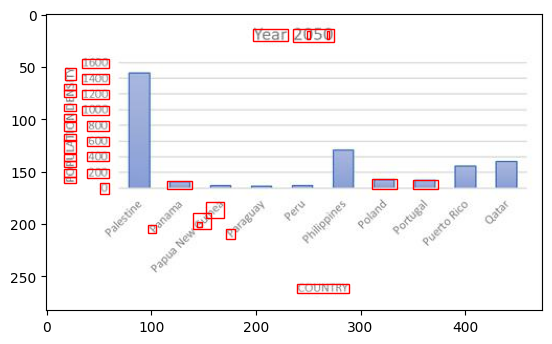

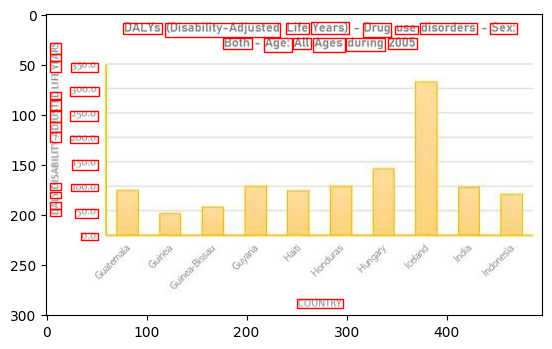

In [78]:
for img in annotations_train.image.values[:10]:
    extract_labels(img)